Acknowledgements - https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/notebooks

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
from nltk.corpus import stopwords # text preprocessing - stopwords
import re, string, unicodedata # text preprocessing - regular expressions, string
from bs4 import BeautifulSoup # html processing
from wordcloud import WordCloud, STOPWORDS # visualizing word cloud from corpus & ignoring stopwords
from collections import Counter # counter for most common words
from sklearn.feature_extraction.text import CountVectorizer # feature-oriented counting of words
from sklearn.model_selection import train_test_split # splitting the dataset into train & test sets
from keras.preprocessing import text, sequence # word tokenization
from keras.models import Sequential # class to construct the model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten # RNN layers to be used
from keras.optimizers import Adam # optimizer to be used
from keras.callbacks import ReduceLROnPlateau # learning rate decay on plateau

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nabhsanjaymehtautd","key":"ee0e2e2e8b50d345f23e44404b090088"}'}

In [ ]:
!mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 60 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
terenceshin/covid19s-impact-on-airport-traffic            COVID-19's Impact on Airport Traffic               106KB  2020-10-19 12:40:17           1885  
sootersaalu/amazon-top-50-bestselling-books-2009-2019     Amazon Top 50 Bestselling Books 2009 - 2019         15KB  2020-10-13 09:39:21           1810  
thomaskonstantin/highly-rated-children-books-and-stories  Highly Rated Children Books And Stories            106KB  2020-10-24 12:09:59            379  
tunguz/euro-parliament-proceedings-1996-2011              Euro Parliament Proceedings 1996 - 2011              1GB  2020-10-26 17:48:29             26  
rishidamarla/judicial-expenditures-across-all-50-states   Judicial Expenditures ac

In [ ]:
!kaggle competitions download -c transferlearning-dl-spring2020

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip train.csv.zip -d train

Archive:  train.csv.zip
replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/train.csv         


In [ ]:
data = pd.read_csv('/content/train/train.csv', encoding = "ISO-8859-1")
testdata = pd.read_csv('/content/test.csv', encoding="ISO-8859-1")

In [ ]:
data.head()

,id,text,target
0,86426,@USER She should ask a few native Americans wh...,1
1,16820,Amazon is investigating Chinese employees who ...,0
2,62688,"@USER Someone should'veTaken"" this piece of sh...",1
3,43605,@USER @USER Obama wanted liberals &amp; illega...,0
4,97670,@USER Liberals are all Kookoo !!!,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


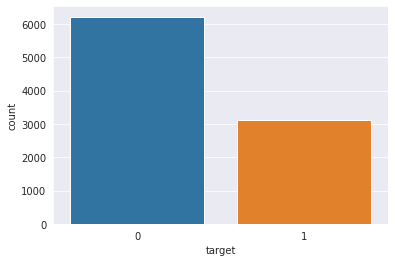

In [ ]:
sns.set_style('darkgrid')
sns.countplot(data.target)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
data['text']=data['text'].apply(denoise_text)

In [ ]:
data.head()

,id,text,target
0,86426,ask native americans take,1
1,16820,amazon investigating chinese employees selling...,0
2,62688,someone piece shit,1
3,43605,obama wanted liberals illegals move red states,0
4,97670,liberals kookoo,1


Text(0.5, 0.98, 'Character Count in Reviews')

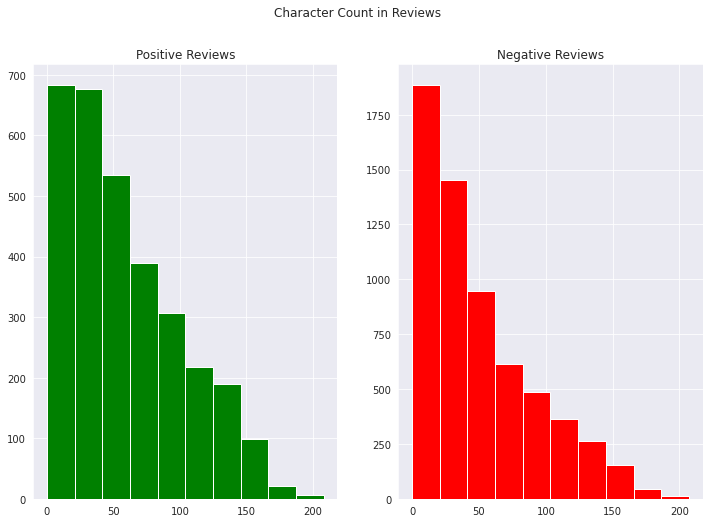

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
text_len = data[data['target'] == 1]['text'].str.len()
ax1.set_title('Positive Reviews')
ax1.hist(text_len, color='green')
text_len = data[data['target'] == 0]['text'].str.len()
ax2.set_title('Negative Reviews')
ax2.hist(text_len, color='red')
fig.suptitle('Character Count in Reviews')

In [ ]:
def get_top_ngrams(corpus, n, g):
    
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

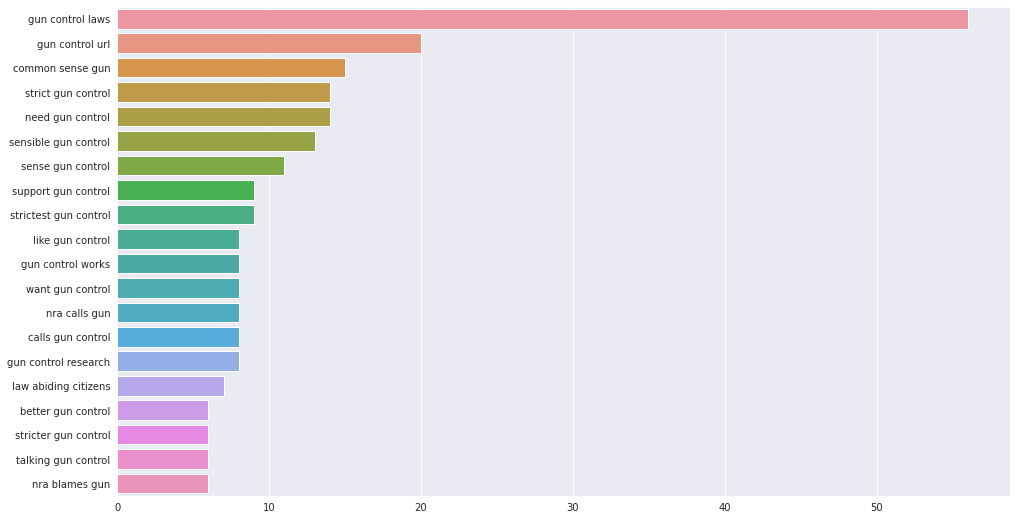

In [ ]:
plt.figure(figsize=(16, 9))
most_common_uni = dict(get_top_ngrams(data.text, 20, 3))
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, 
                                                    train_size=0.9, 
                                                    random_state=0)
X_test_temp = X_test
y_test_temp = y_test

In [ ]:
max_features = 10000
max_len = 128

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-11-03 20:37:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-03 20:37:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-03 20:37:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

 gdrive		     glove.6B.50d.txt  'kaggle (1).json'        test.csv
 glove.6B.100d.txt   glove.6B.zip       kaggle.json	        train
 glove.6B.200d.txt   glove.6B.zip.1     sample_data	        train.csv.zip
 glove.6B.300d.txt   glove.6B.zip.2     sample_submission.csv
/content


In [ ]:
EMBEDDING_FILE ="/content/glove.6B.300d.txt"

In [ ]:
def get_coeffs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_dict = dict(get_coeffs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_dict.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embed_size))

for word, i in word_index.items():
    
    if i >= num_words: continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
batch_size = 256
epochs=10
embed_size=300

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
from keras import backend as K

In [ ]:
def f_score(y_true, y_pred, threshold=0.1, beta=2):

    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

In [ ]:
def tp_score(y_true, y_pred, threshold=0.1):

    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))

    return tp


def fp_score(y_true, y_pred, threshold=0.1):

    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))

    return fp


def fn_score(y_true, y_pred, threshold=0.1):

    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))

    return fn


def precision_score(y_true, y_pred, threshold=0.1):

    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)

    return tp / (tp + fp)


def recall_score(y_true, y_pred, threshold=0.1):

    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    return tp / (tp + fn)

In [ ]:
model = Sequential()

model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(rate=0.8))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.002), loss='binary_crossentropy', 
              metrics=f_score)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,443,425
Trainable params: 443,425
Non-trainable params: 3,000,000
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/10
33/33 [==============================] - 2s 73ms/step - loss: 0.6321 - f_score: 0.7129 - val_loss: 0.5864 - val_f_score: 0.7172
Epoch 2/10
33/33 [==============================] - 2s 48ms/step - loss: 0.5678 - f_score: 0.7190 - val_loss: 0.5355 - val_f_score: 0.7180
Epoch 3/10
33/33 [==============================] - 2s 48ms/step - loss: 0.5366 - f_score: 0.7190 - val_loss: 0.5132 - val_f_score: 0.7203
Epoch 4/10
33/33 [==============================] - 2s 48ms/step - loss: 0.5190 - f_score: 0.7280 - val_loss: 0.5102 - val_f_score: 0.7290
Epoch 5/10
33/33 [==============================] - 2s 48ms/step - loss: 0.5085 - f_score: 0.7302 - val_loss: 0.5158 - val_f_score: 0.7342
Epoch 6/10
33/33 [==============================] - 2s 48ms/step - loss: 0.4942 - f_score: 0.7346 - val_loss: 0.5067 - val_f_score: 0.7297
Epoch 7/10
33/33 [==============================] - 2s 48ms/step - loss: 0.4860 - f_score: 0.7389 - val_loss: 0.5085 - val_f_score: 0.7313
Epoch 8/10
33/33 [=========

In [ ]:
print("Model Accuracy on Training Data: ", round(model.evaluate(X_train, y_train)[1]*100), "%")
print("Model Accuraccy on Testing Data: ", round(model.evaluate(X_test, y_test)[1]*100), "%")

263/263 [==============================] - 2s 8ms/step - loss: 0.3937 - f_score: 0.7533
Model Accuracy on Training Data:  75 %
30/30 [==============================] - 0s 7ms/step - loss: 0.5382 - f_score: 0.7171
Model Accuraccy on Testing Data:  72 %


In [ ]:
history.history

{'f_score': [0.7128528952598572,
  0.7189640998840332,
  0.7189900875091553,
  0.7280216217041016,
  0.7301872372627258,
  0.7346366047859192,
  0.7388955354690552,
  0.745067298412323,
  0.7518593072891235,
  0.7619423270225525],
 'loss': [0.632097601890564,
  0.5678114891052246,
  0.5365914106369019,
  0.5190249681472778,
  0.5085451006889343,
  0.49418380856513977,
  0.48599594831466675,
  0.46534425020217896,
  0.4460606575012207,
  0.4260425567626953],
 'lr': [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001],
 'val_f_score': [0.7171559929847717,
  0.7179653644561768,
  0.7203402519226074,
  0.729023814201355,
  0.7342402338981628,
  0.7296569347381592,
  0.7313453555107117,
  0.7338710427284241,
  0.7306410074234009,
  0.7306411862373352],
 'val_loss': [0.5863938331604004,
  0.5354620218276978,
  0.5131537318229675,
  0.5101721882820129,
  0.515751302242279,
  0.5066903233528137,
  0.5085200667381287,
  0.5074759721755981,
  0.5249583721160889,
  0.53824007511

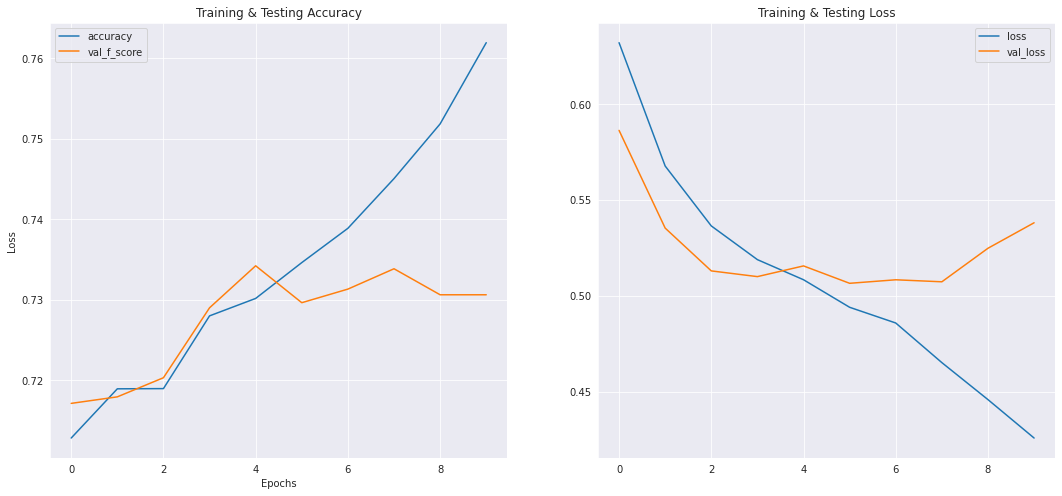

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.plot(history.history['f_score'])
ax1.plot(history.history['val_f_score'])
ax1.set_title('Training & Testing Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['accuracy', 'val_f_score'])
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Training & Testing Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.legend(['loss', 'val_loss'])

In [ ]:
testdata['text']=testdata['text'].apply(denoise_text)

In [ ]:
testdata_X = testdata['text']

In [ ]:
testdata_X.head()

0                                 go home url
1                                    oh tough
2    canada need another already enough great
3           scare every playing hockey warped
4                  throwing bullshit flag url
Name: text, dtype: object

In [ ]:
max_features = 10000
max_len = 128

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(testdata_X)

tokenized_train = tokenizer.texts_to_sequences(testdata_X)
testdata_X = sequence.pad_sequences(tokenized_train, maxlen=max_len)


In [ ]:
predictions = model.predict(testdata_X)

In [ ]:
type(predictions)

numpy.ndarray

In [ ]:
submit = pd.DataFrame(data=predictions, columns=['target'])

In [ ]:
submit

,target
0,0.076413
1,0.088850
2,0.309796
3,0.425224
4,0.056183
...,...
3889,0.150014
3890,0.072804
3891,0.651642
3892,0.563634


In [ ]:
submit1 = pd.DataFrame(data=testdata['id'], columns=['id'])

In [ ]:
submit1

,id
0,90194
1,77444
2,13384
3,54920
4,56117
...,...
3889,90041
3890,98824
3891,95338
3892,67210


In [ ]:
submit1['target'] = submit['target']

In [ ]:
submit1.to_csv('/content/gdrive/My Drive/submit2.csv', index = False)

In [ ]:
submit1

,id,target
0,90194,0.076413
1,77444,0.088850
2,13384,0.309796
3,54920,0.425224
4,56117,0.056183
...,...,...
3889,90041,0.150014
3890,98824,0.072804
3891,95338,0.651642
3892,67210,0.563634
